In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
results_dir = "results/figures/"
from pdf2image import convert_from_path
for data_type in ["standardised", "original"]:
    for sample_id in range(1,5):
        for experiment in range(1,4):
            pages = convert_from_path(results_dir+f"{data_type}/sample_{sample_id}_experiment_{experiment}.pdf", 500)
            for page in pages:
                page.save(results_dir+f"{data_type}/sample_{sample_id}_experiment_{experiment}.jpg", 'JPEG')

In [7]:
from IPython.display import Image, display
# for data_type in ["standardised", "original"]:
#     print(data_type)
#     for sample_id in range(1,5):
#         for experiment in range(1,4):
#             print(f"Sample {sample_id}, experiment {experiment}")
#             display(Image(filename=f'results/figures/{data_type}/sample_{sample_id}_experiment_{experiment}.jpg')) 

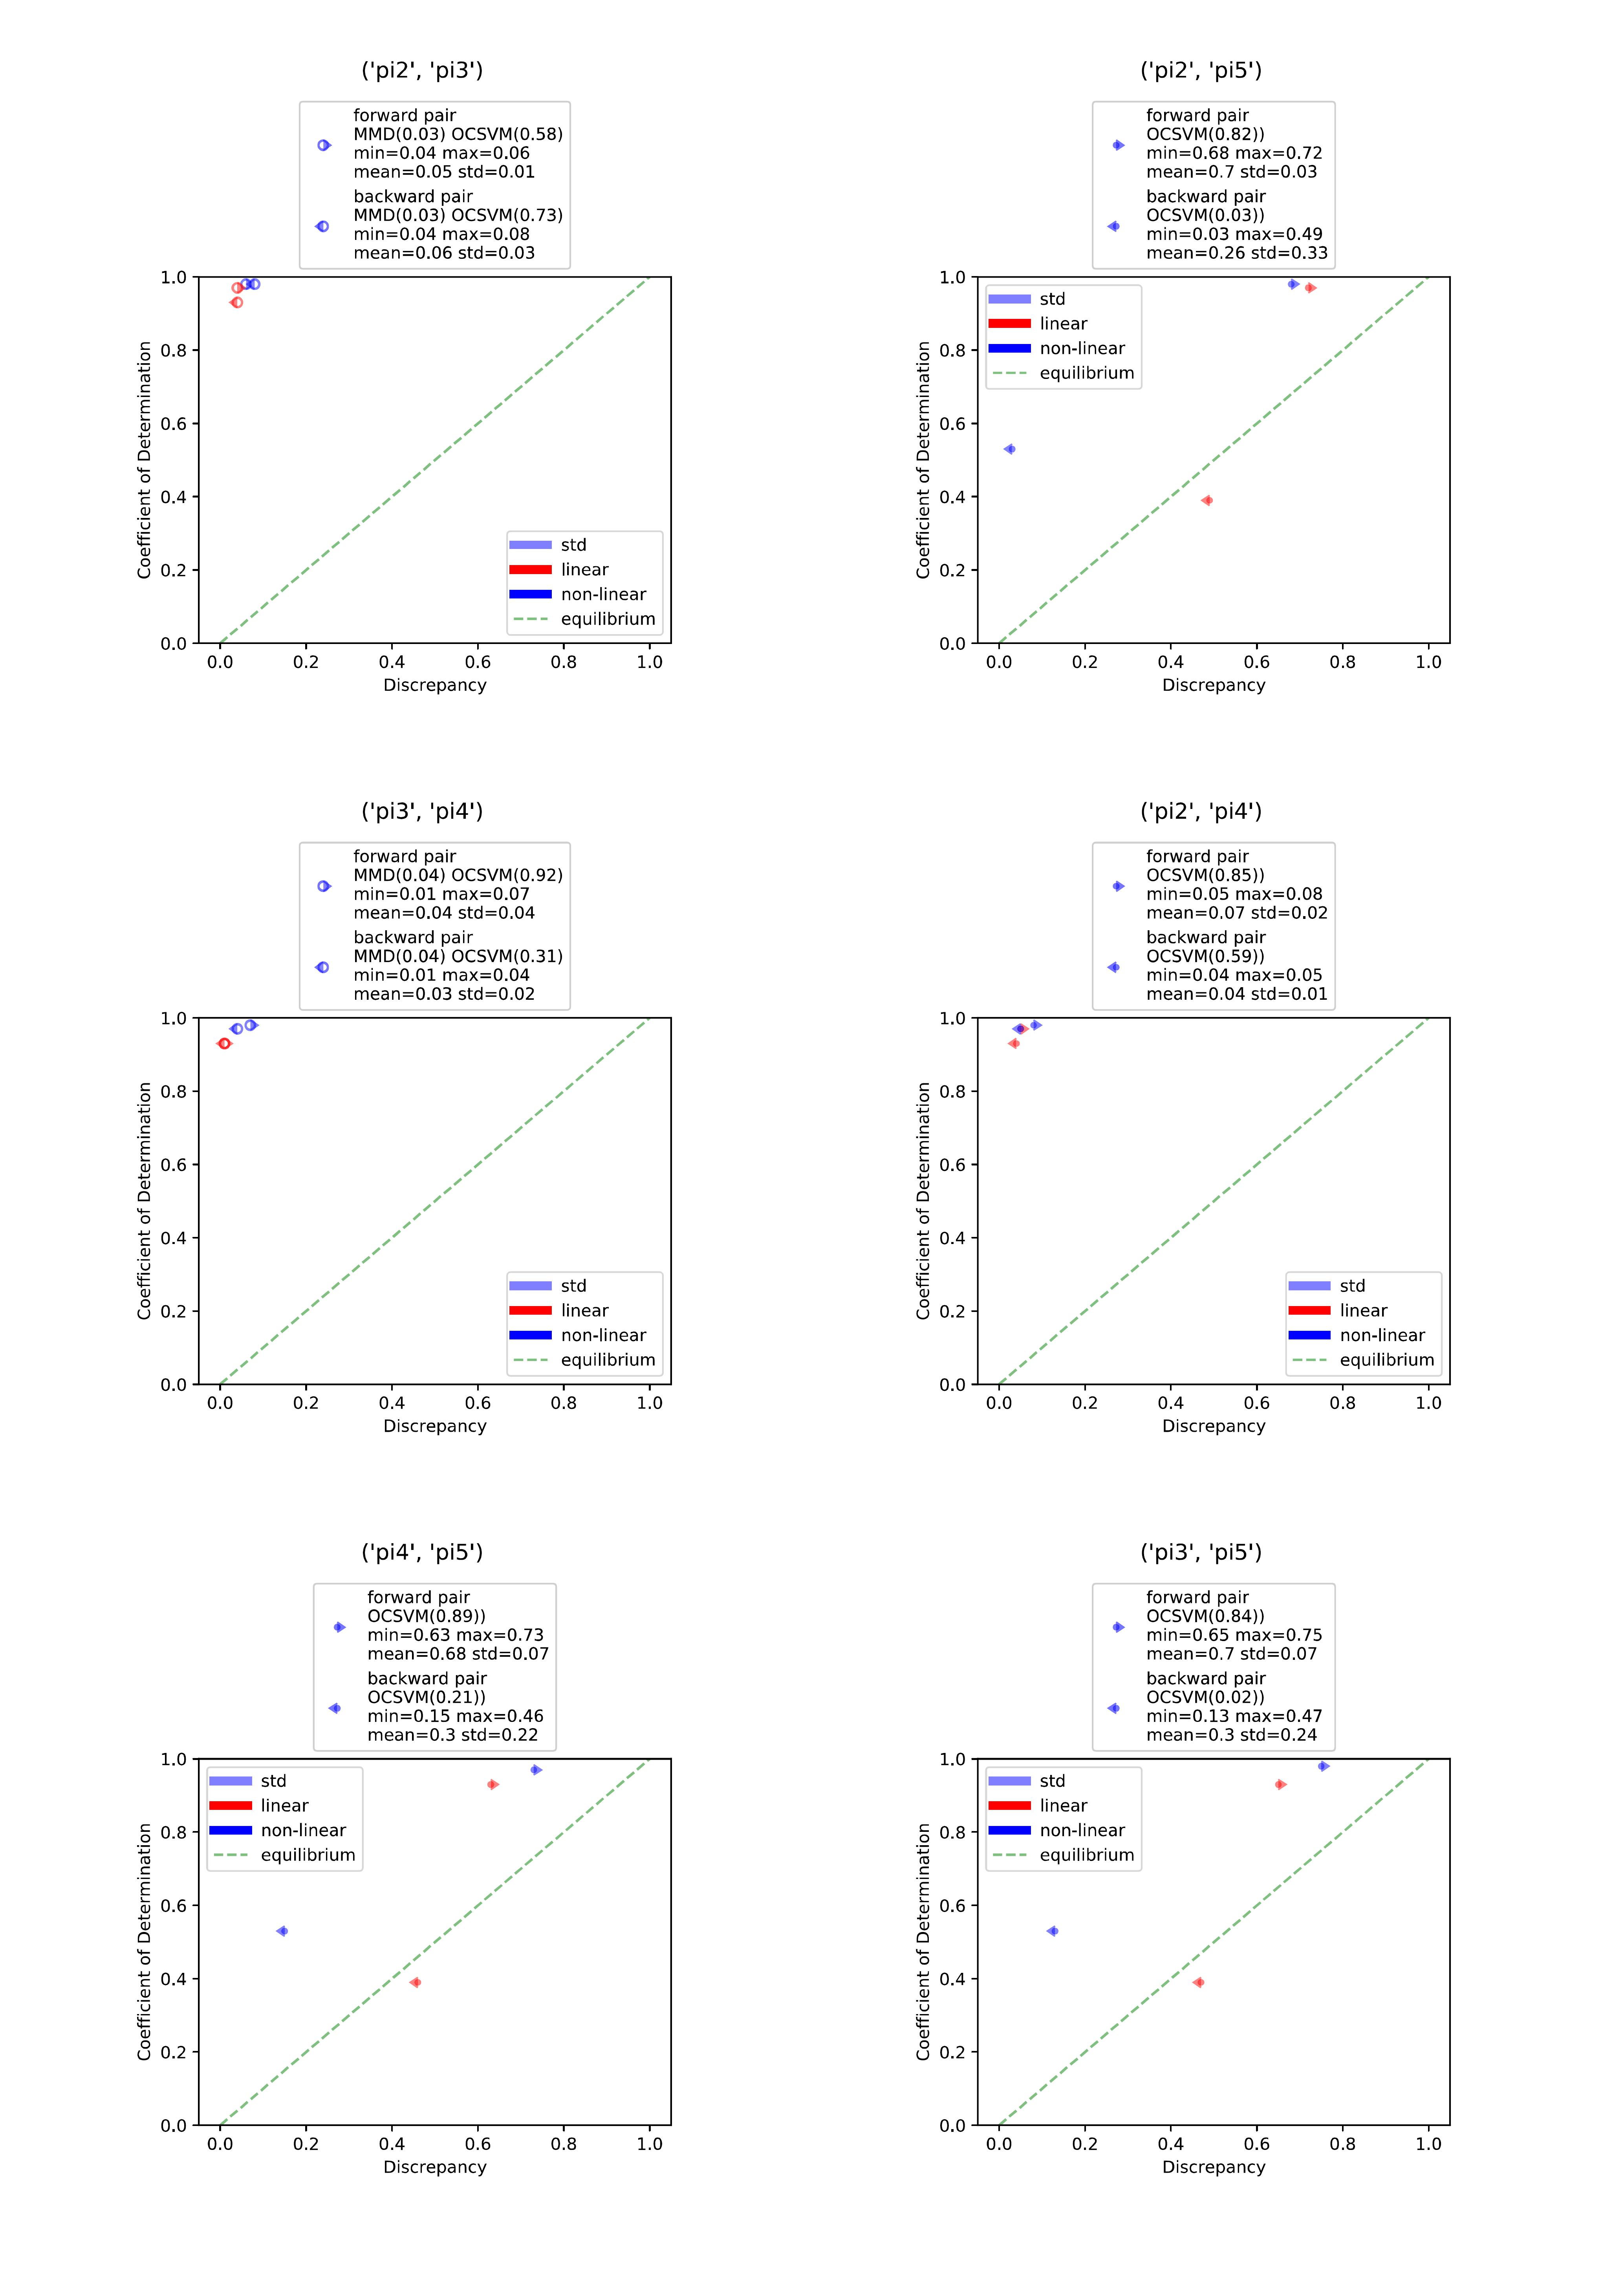

results/figures/standardised/sample_1_experiment_1.jpg


In [11]:
data_type = "standardised"
sample_id = 1
experiment = 1
name = f'results/figures/{data_type}/sample_{sample_id}_experiment_{experiment}.jpg'
display(Image(filename=name))
print(name)

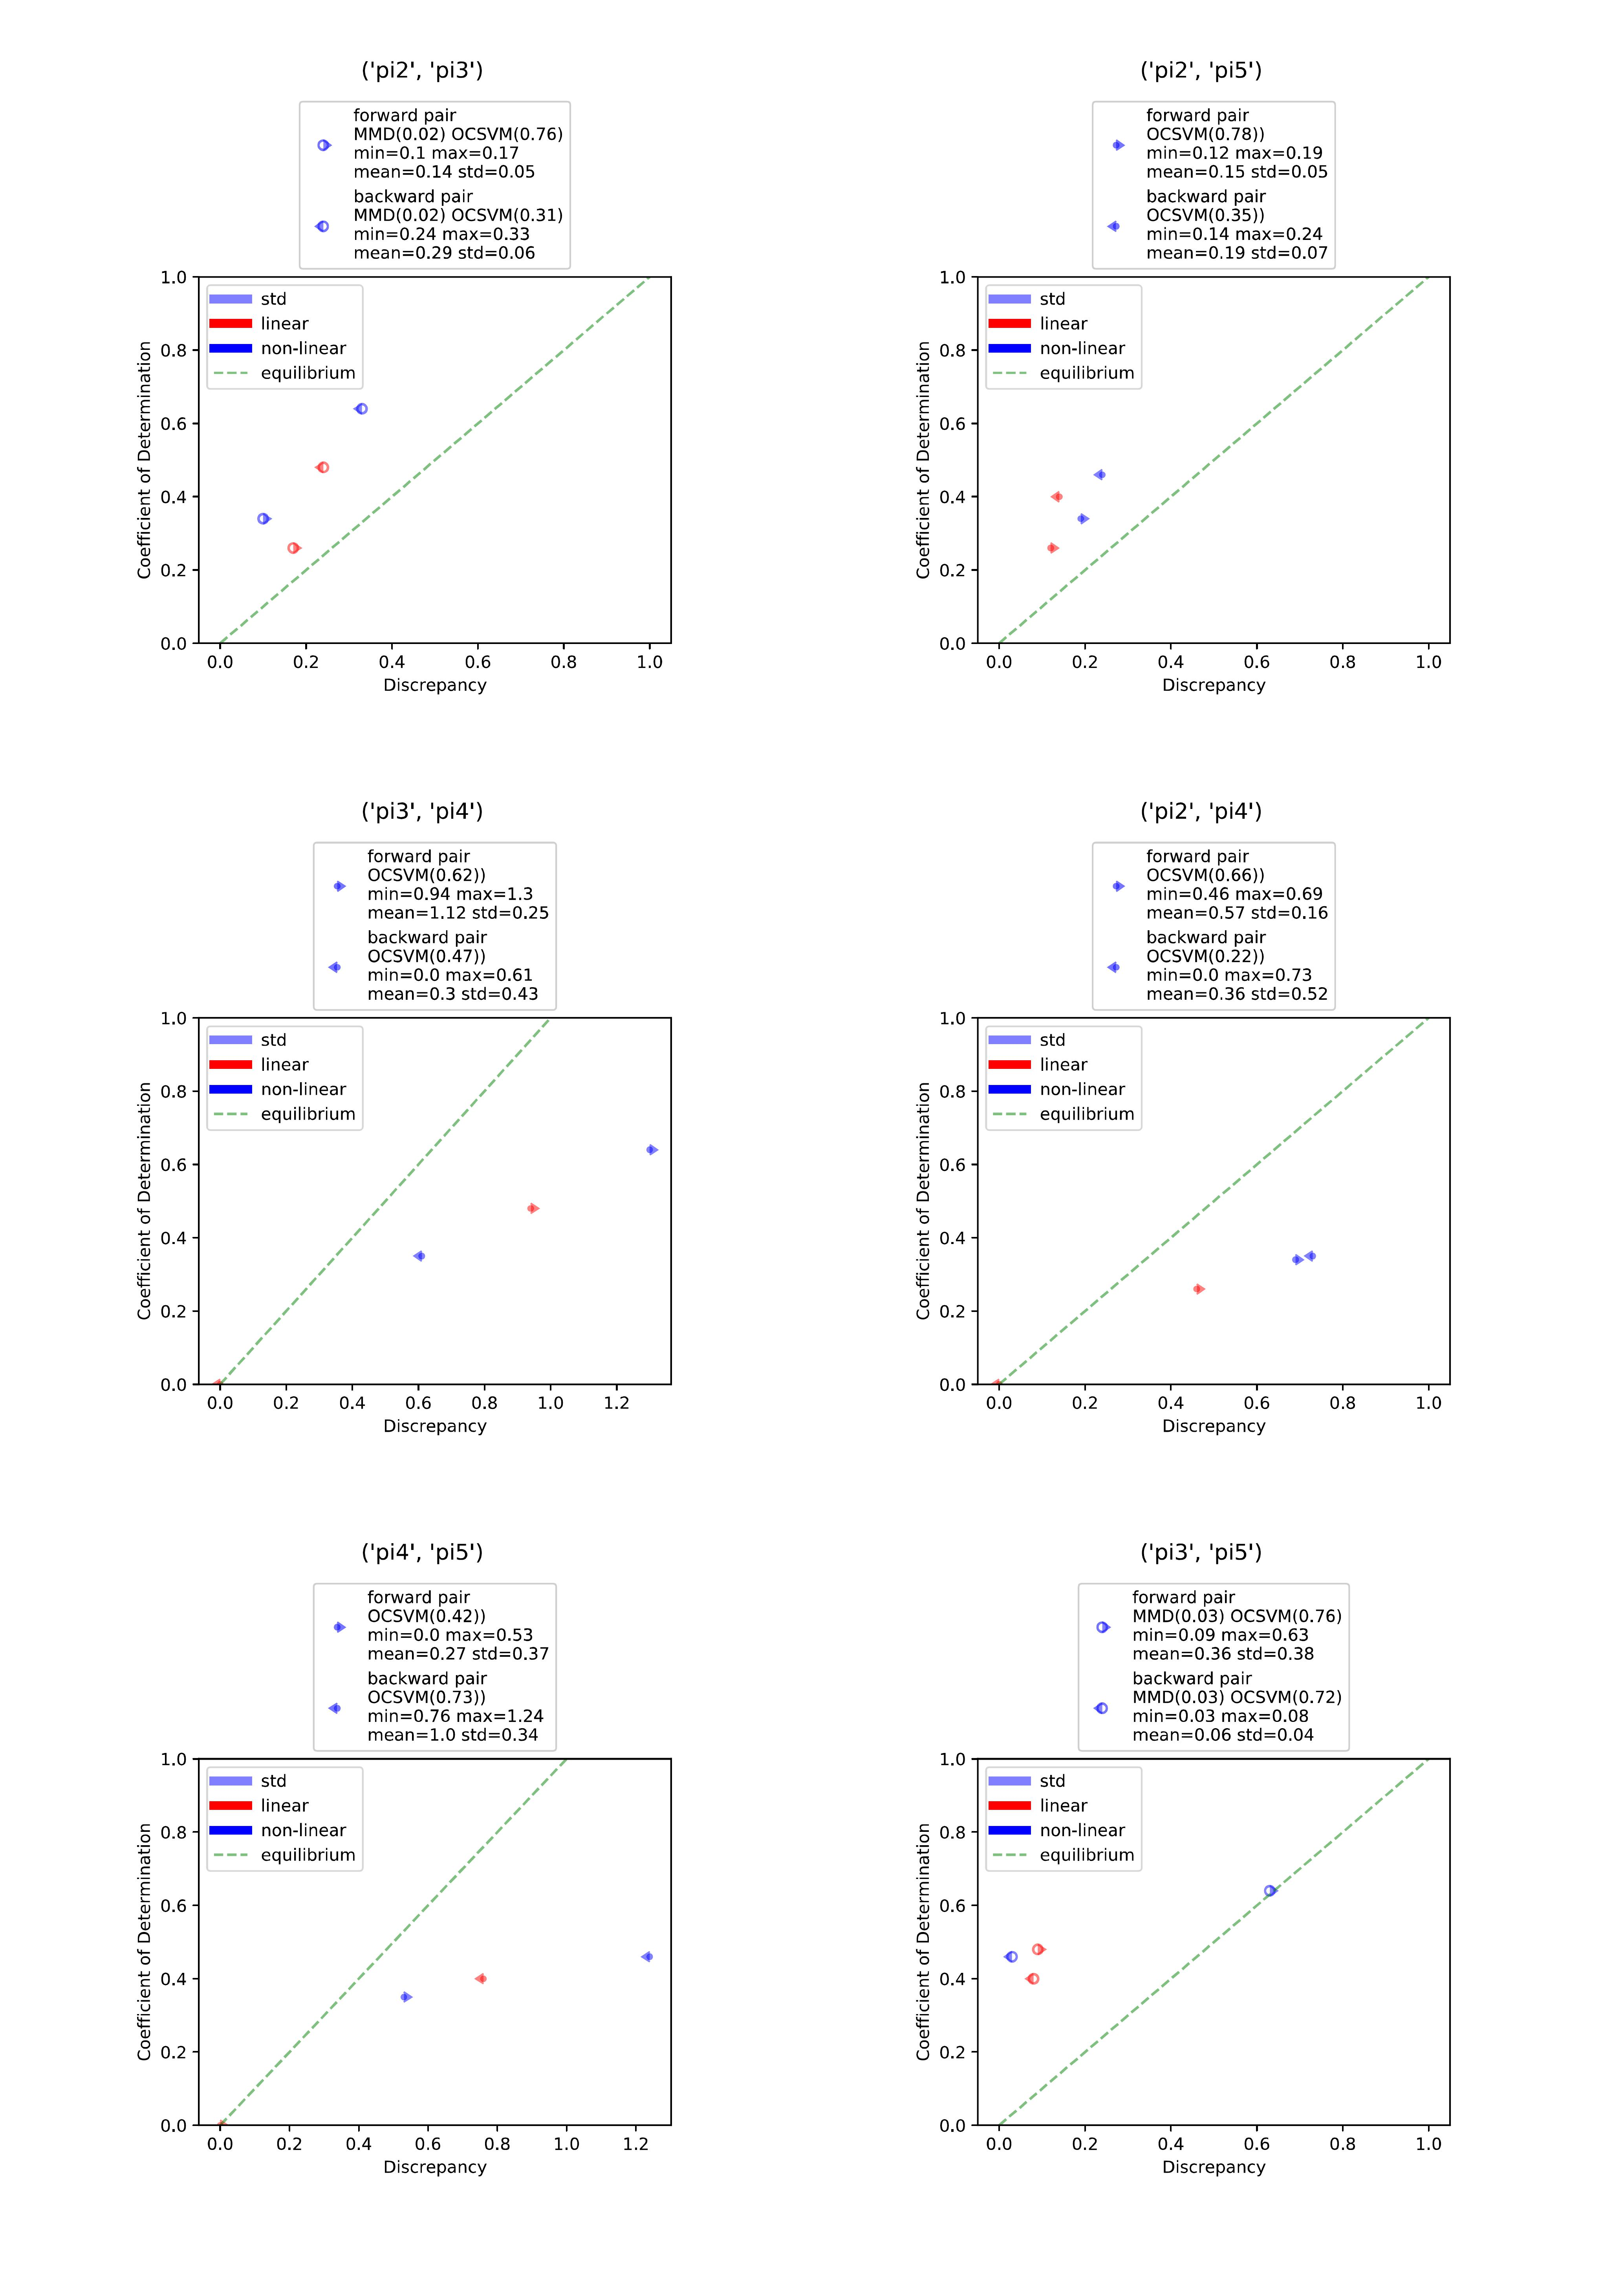

results/figures/standardised/sample_1_experiment_2.jpg


In [12]:
data_type = "standardised"
sample_id = 1
experiment = 2
name = f'results/figures/{data_type}/sample_{sample_id}_experiment_{experiment}.jpg'
display(Image(filename=name))
print(name)

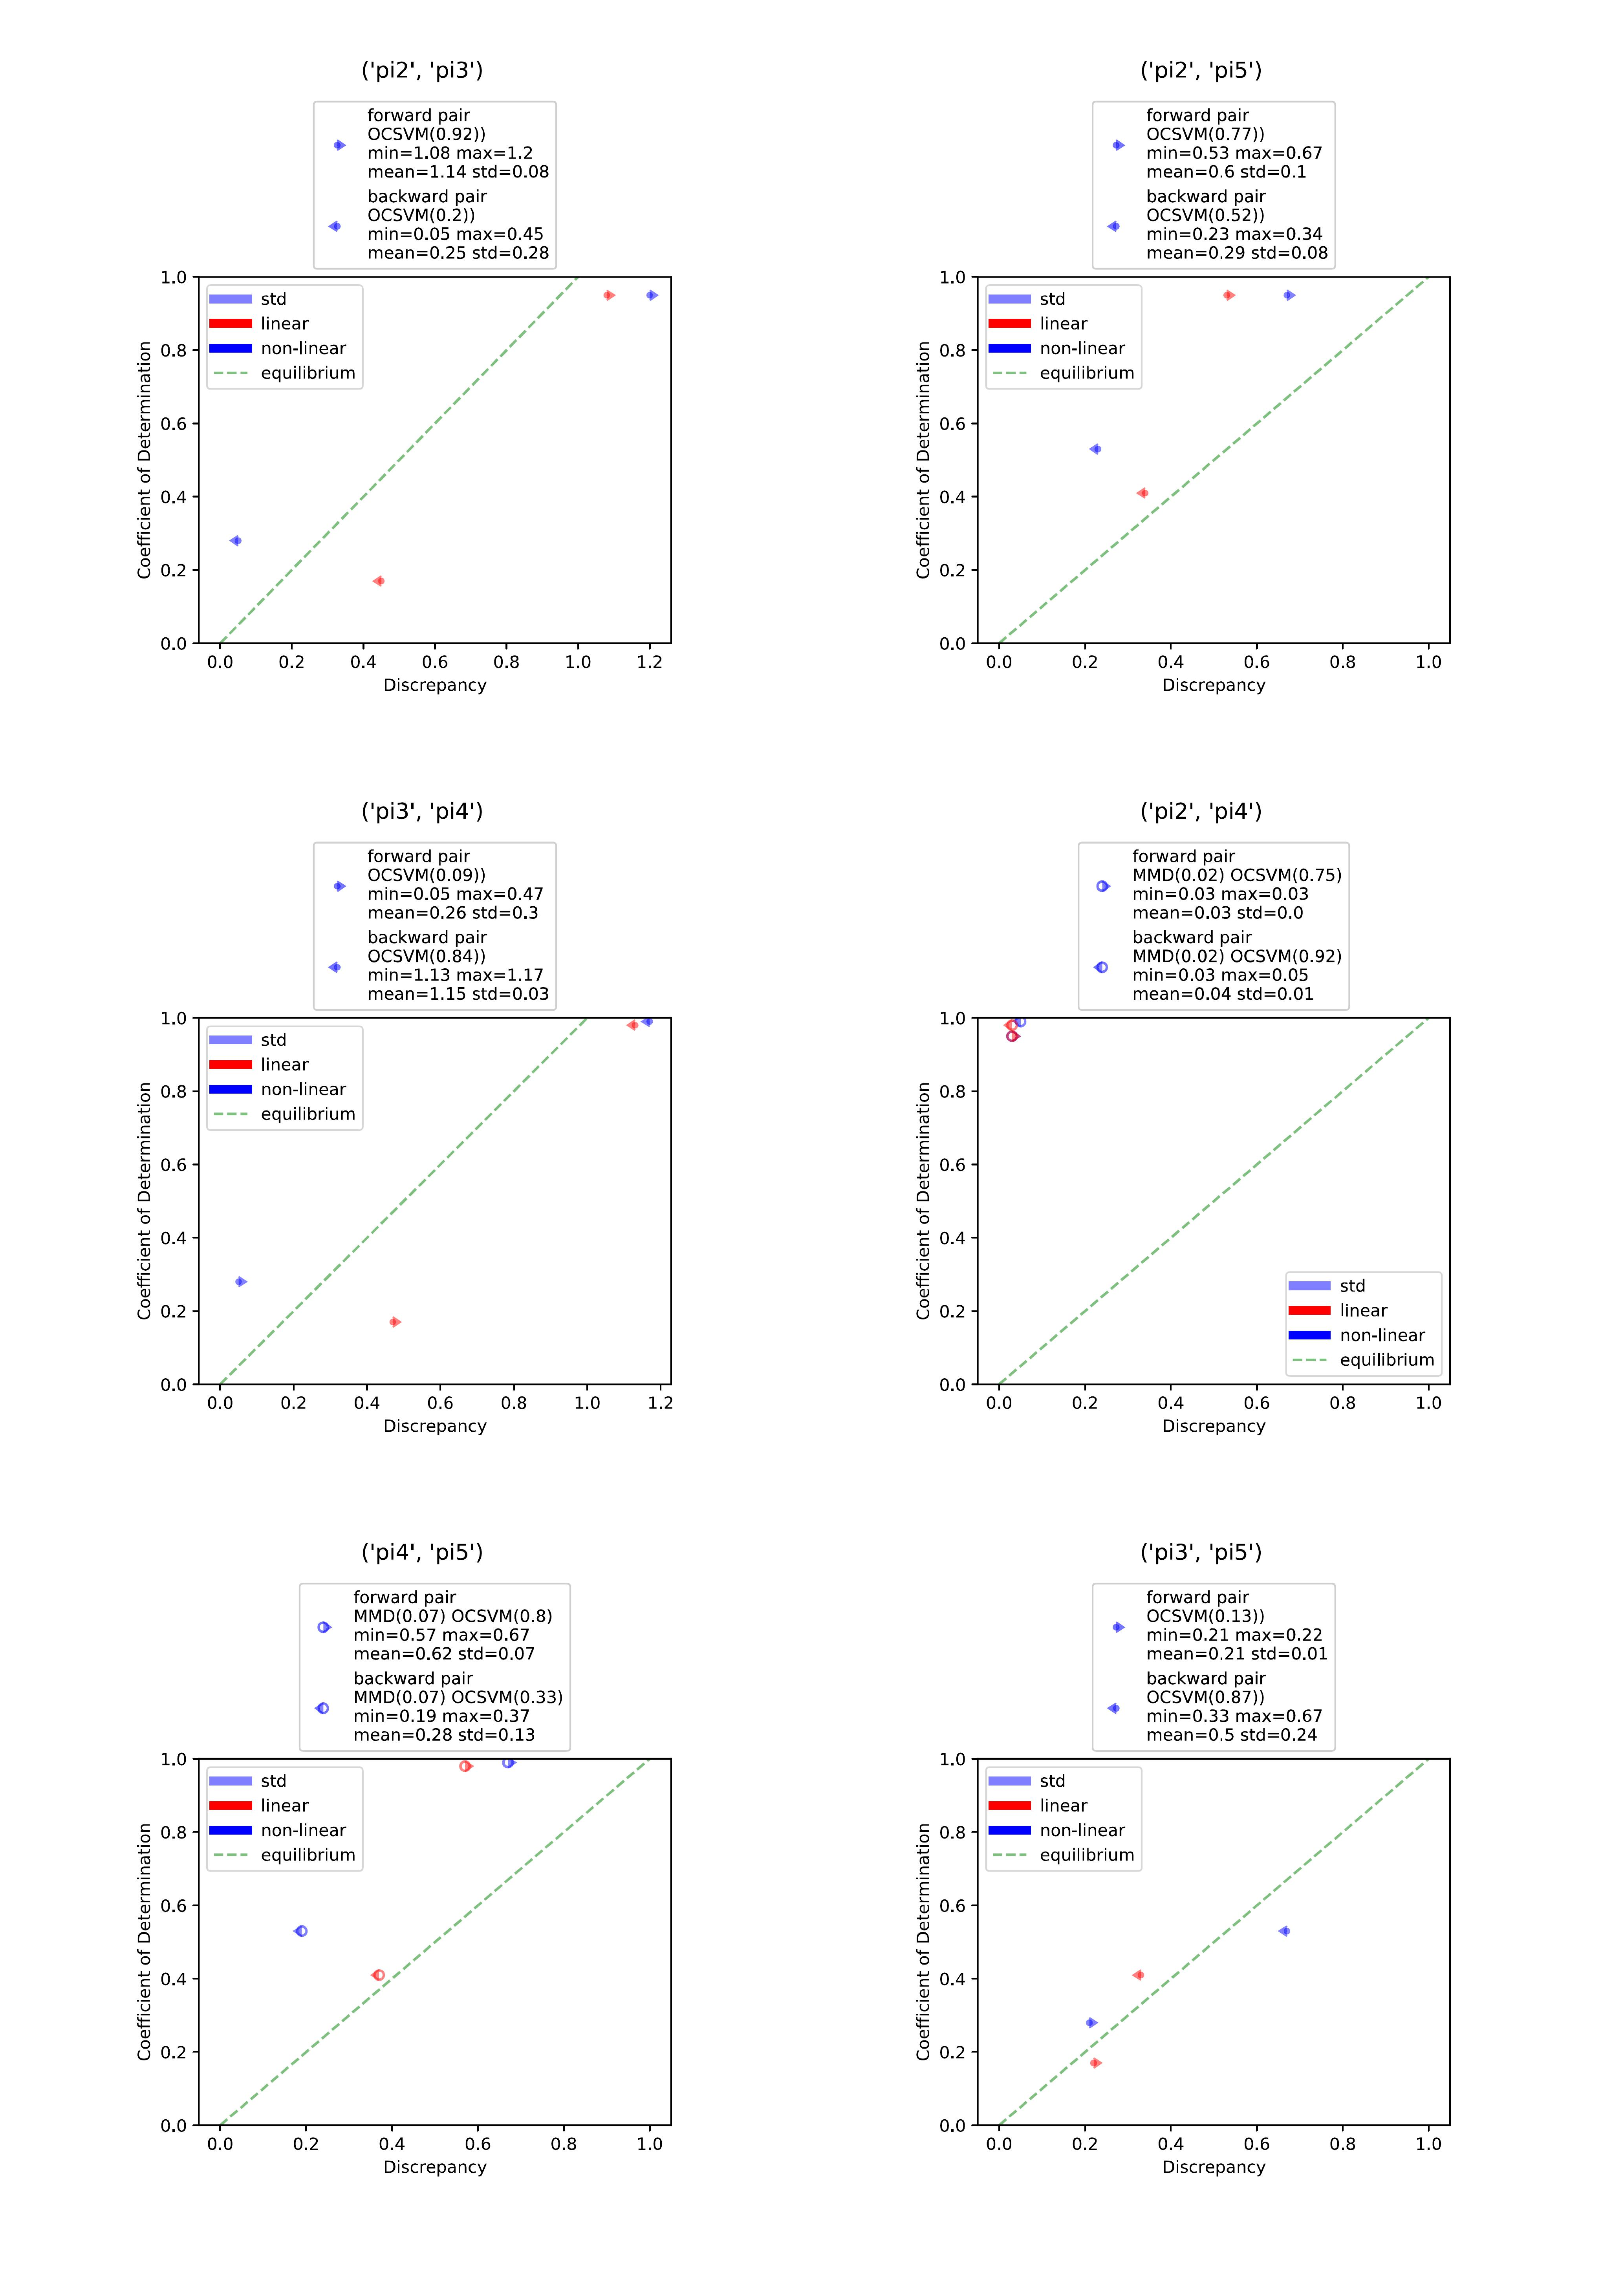

results/figures/standardised/sample_1_experiment_3.jpg


In [13]:
data_type = "standardised"
sample_id = 1
experiment = 3
name = f'results/figures/{data_type}/sample_{sample_id}_experiment_{experiment}.jpg'
display(Image(filename=name))
print(name)